# Self-organized criticality

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 8

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import Hist, Cdf

from matplotlib import rc
rc('animation', html='html5')

## Sand pile

`Sand.py` contains an implementation of the sand pile model.

In [2]:
from Sand import SandPile, SandPileViewer

Here's a small example starting with two cells ready to topple.  `n` is the number of rows, `m` is the number of columns.

In [3]:
pile = SandPile(n=3, m=5, level=0)
pile.array[1, 1] = 4
pile.array[1, 3] = 4

a = pile.array
print(a)

[[0 0 0 0 0]
 [0 4 0 4 0]
 [0 0 0 0 0]]


To execute one step, first we find cells that are above the toppling threshold, `K`.

In [4]:
K = 3
toppling = a > K
print(toppling.astype(int))

[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]]


Then we use `correlate2d` to make a copy of the update kernel around each toppling cell.

In [5]:
kernel = np.array([[0, 1, 0],
                   [1,-4, 1],
                   [0, 1, 0]], 
                  dtype=np.int32)

from scipy.signal import correlate2d

c = correlate2d(toppling, kernel, mode='same', boundary='fill', fillvalue=0)
print(c)

[[ 0  1  0  1  0]
 [ 1 -4  2 -4  1]
 [ 0  1  0  1  0]]


Finally, we add the result back into the array:

In [6]:
a += c
print(a)

[[0 1 0 1 0]
 [1 0 2 0 1]
 [0 1 0 1 0]]


Any grains that topple off the edge disappear.

## Animation

Let's look at a bigger pile, with `n=20`.  All cells are initialized to `level`, which is meant to be substantially bigger than `K`.

In [7]:
pile = SandPile(n=20, level=10)
print(pile.run())

(332, 53336)


The `run` function invokes `step` until no more cells topple and returns the number of time steps and the number of affected cells.

Now let's look at an animation, starting from this initialized pile.

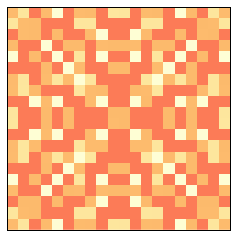

In [8]:
viewer = SandPileViewer(pile, drop_flag=True)
anim = viewer.animate(frames=100)

Starting with `level>K` produces all kinds of interesting patterns.

Each step of the animation drops a single grain at a random location and runs until no more cells topple.

Most avalanches are small, but some are very large.

In [9]:
anim

After a while, the pile looks pretty random.

Here's a plot of the number of cells toppled after each `step`.  

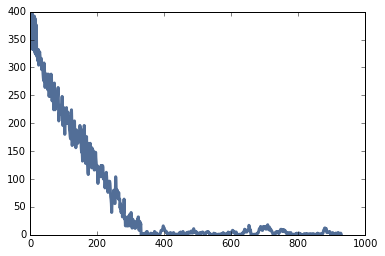

In [10]:
thinkplot.plot(pile.toppled_seq)

The following figure shows the progression of the pile from ordered to apparently random.

(332, 53336)


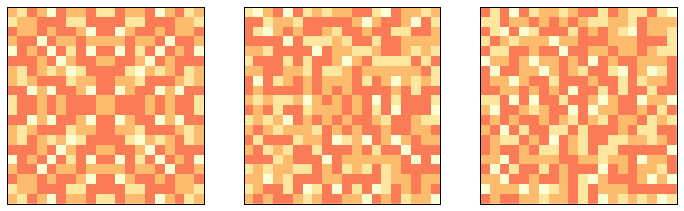

In [11]:
pile = SandPile(n=20, level=10)
print(pile.run())
viewer = SandPileViewer(pile)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(200):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(200):
    viewer.step()
viewer.draw()

plt.savefig('chap08-1.pdf')

## Long tailed distributions

If the sand pile is in a critical state, we expect quantities like the duration of an avalanche, `T`, and the number of cells affected, `S`, to have long-tailed distributions.

Following Bak, Tang, and Wiesenseld, we start with a 50x50 array and plot the PMFs of `S` and `T` on a log-log scale.

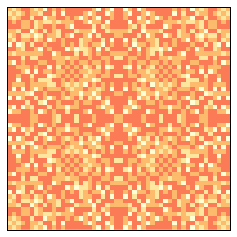

In [12]:
pile2 = SandPile(n=50, level=30)
pile2.run()
viewer = SandPileViewer(pile2)
viewer.draw()

Now we run the pile for many time steps and keep track of the durations and number of cells affected.

In [13]:
iters = 100000
%time res = [pile2.drop_and_run() for _ in range(iters)]

CPU times: user 3min 1s, sys: 152 ms, total: 3min 2s
Wall time: 3min 1s


And extract the results into two NumPy arrays.

In [50]:
T, S = np.transpose(res)

A large majority of drops have duration 1 and no toppled cells, so we'll filter those out.

In [51]:
T = T[T>1]
S = S[S>0]

The distributions of `T` and `S` have many small values and a few very large ones.

Here are the histograms on linear axes, showing only small values.

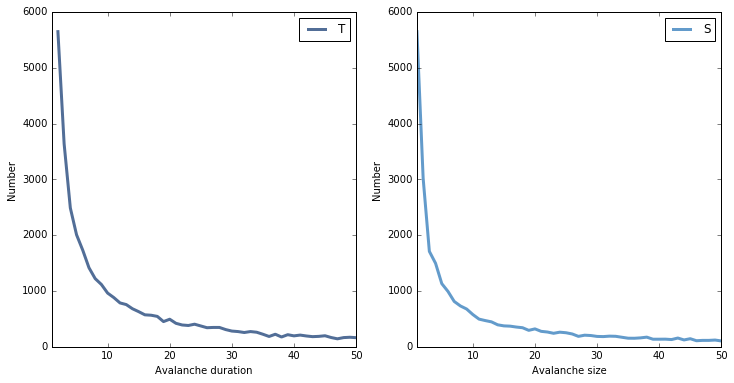

In [48]:
thinkplot.preplot(cols=2)

histT = Hist(T)
thinkplot.Pdf(histT, label='T')
thinkplot.config(xlabel='Avalanche duration',
                 ylabel='Number',
                 xlim=[1, 50], loc='upper right')

thinkplot.subplot(2)

histS = Hist(S)
thinkplot.Pdf(histS, label='S')
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Number',
                 xlim=[1, 50])

plt.savefig('chap08-2.pdf')

To see whether these distributions follow a power law, we plot the histograms on a log-log scale.

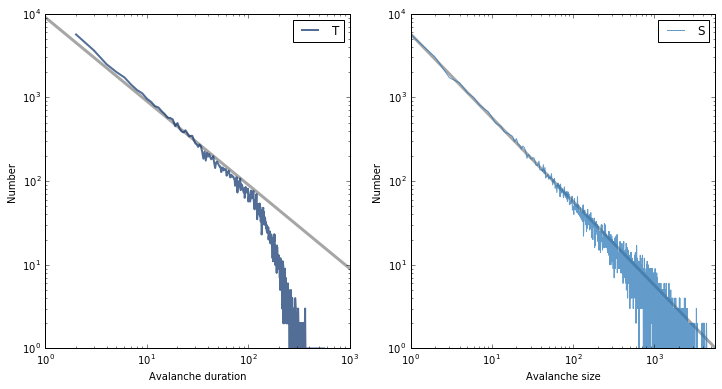

In [17]:
thinkplot.preplot(cols=2)

x = 9000
thinkplot.plot([1, x], [x, 1], color='gray', linewidth=3)
thinkplot.Pdf(histT, label='T', linewidth=2)
thinkplot.config(xlabel='Avalanche duration',
                 xlim=[1, 1000],
                 ylabel='Number',
                 xscale='log',
                 yscale='log',
                 loc='upper right')

thinkplot.subplot(2)

x = 5700
thinkplot.plot([1, x], [x, 1], color='gray', linewidth=3)
thinkplot.Pdf(histS, label='S', linewidth=1)
thinkplot.config(xlabel='Avalanche size',
                 xlim=[1, 5600],
                 ylabel='Number',
                 xscale='log',
                 yscale='log')

plt.savefig('chap08-3.pdf')

The gray line has slope -1.  The distribution of avalanche duration is approximately straight between 1 and 100, but then drops off.  The distribution of size follows a power law more closely and over a greater range, but it also seems to drop off for values above a few hundred.

**Exercise:** Try running the model longer to see if you can get a less noisy plot of the distributions of `T` and `S`.

## Fractals

If the sand pile is in a critical state, we expect to see fractal geometry.

To estimate the fractal dimension, I'll start with a bigger pile and a higher initial level.

In [18]:
pile3 = SandPile(n=131, level=22)
%time pile3.run()

CPU times: user 19 s, sys: 24 ms, total: 19.1 s
Wall time: 19 s


(28379, 211320220)

The initial state sure looks like a fractal.

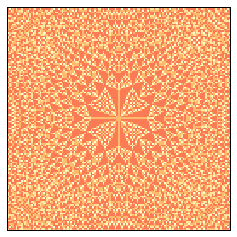

In [19]:
viewer3 = SandPileViewer(pile3)
viewer3.draw()

Since it contains four different levels (0, 1, 2, and 3), we can extract 4 binary patterns.

In [20]:
def draw_four(viewer, vals=range(4)):
    thinkplot.preplot(rows=2, cols=2)
    a = viewer.viewee.array
    
    for i, val in enumerate(vals):
        thinkplot.subplot(i+1)
        viewer.draw_array(a==vals[i], vmax=1)

Here's what they look like:

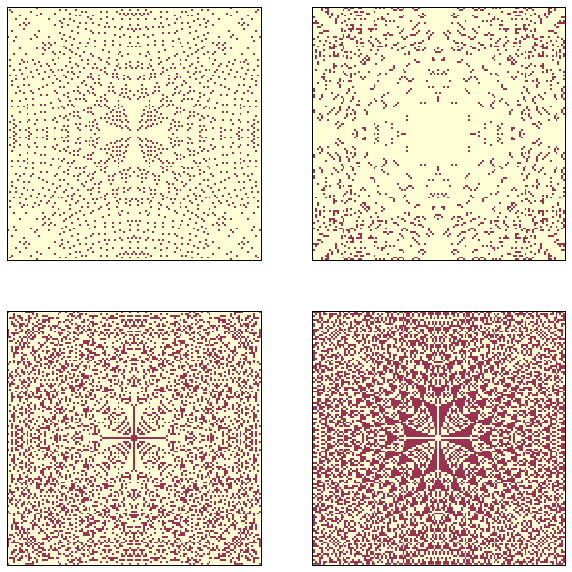

In [21]:
draw_four(viewer3)
plt.savefig('chap08-4.pdf')

Now we can apply a box-counting algorithm to each level.

`count_cells` starts with a single cell in the middle, gradually increases the size of the box, and counts the number of cells in each box.

In [22]:
def count_cells(a):
    """Counts the number of cells in boxes with increasing size.
    
    a: NumPy array
    
    returns: list of (i, i**2, cell count) tuples
    """
    n, m = a.shape
    end = min(n, m)
    
    res = []
    for i in range(1, end, 2):
        top = (n-i) // 2
        left = (m-i) // 2
        box = a[top:top+i, left:left+i]
        total = np.sum(box)
        res.append((i, i**2, total))
        
    return np.transpose(res)

`box_count` takes a pile and a value, extracts the cells that have the given value, calls `count_cells`, and estimates the fractal dimension.

If `plot` is `True`, it also generates a graph of cell count versus box size on a log-log scale.

In [23]:
from scipy.stats import linregress

def box_count(pile, val=0, plot=False):
    """Estimates the fractal dimension by box counting.
    
    pile: SandPile
    val: which value from the pile to count
    plot: boolean, whether to generate a plot
    
    returns: estimated fractal dimension
    """
    res = count_cells(pile.array==val)
    steps, steps2, cells = res
    
    # select the range where we have a nonzero number of cells
    legit = np.where(cells > 0)
    steps = steps[legit]
    steps2 = steps2[legit]
    cells = cells[legit]

    if plot:
        thinkplot.preplot(3)
        thinkplot.plot(steps, steps2, linestyle='dashed')
        thinkplot.plot(steps, cells, label='val=%d' % val)
        thinkplot.plot(steps, steps, linestyle='dashed')

        thinkplot.config(xscale='log', yscale='log',
                         xlim=[1, 200], loc='upper left',
                         xlabel='box size', ylabel='cell count')
    
    params = linregress(np.log(steps), np.log(cells))
    return params[0]

Finally `box_count_four` applies the box counting algorithm for each value in the sand pile.

In [24]:
def box_count_four(pile, vals=range(4)):
    """Applies box counting to each value in the pile.
    
    pile: SandPile
    vals: list of values to check
    """
    thinkplot.preplot(rows=2, cols=2)
    
    dims = []
    for i, val in enumerate(vals):
        thinkplot.subplot(i+1)
        dim = box_count(pile, val, plot=True)
        dims.append(dim)
        
    return dims

Here are the results:

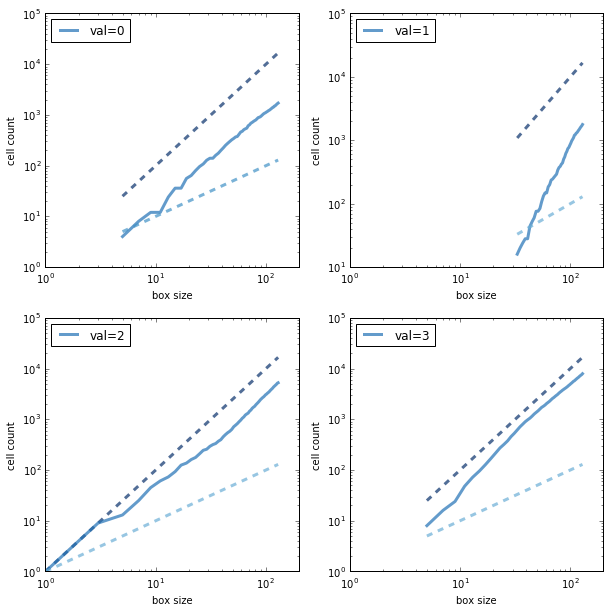

In [25]:
dims = box_count_four(pile3)
plt.savefig('chap08-5.pdf')

The lines are reasonably straight, which indicates that we are running the algorithm over a valid range of box sizes.  Here are the estimated slopes:

In [26]:
for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))

0  1.871
1  3.502
2  1.781
3  2.084


The fractal dimension for values 0, 1, and 2 seems to be clearly non-integer, which indicates that the image is fractal.

Strictly, the fractal dimension for value 3 is indistinguishable from 2, but given the results for the other values, the apparent curvature of the line, and the appearance of the pattern, it seems likely that it is also fractal. 

**Exercise:**  Choose a different value of `n` and/or `level` and run this analysis again.  Are the estimated fractal dimensions consistent?

## Spectral density

Suppose the sandpile made a little click each time a cell toppled.  What would it sound like?

`toppled_seq` contains the number of cells that toppled during each time step.  We can use Welch's algorithm to estimate its [power spectral density](https://en.wikipedia.org/wiki/Spectral_density).

In [53]:
signal = pile2.toppled_seq
len(signal)

1438605

In [54]:
from scipy.signal import welch

nperseg = 2048
freqs, powers = welch(signal, nperseg=nperseg, fs=nperseg)

And here's what it looks like.

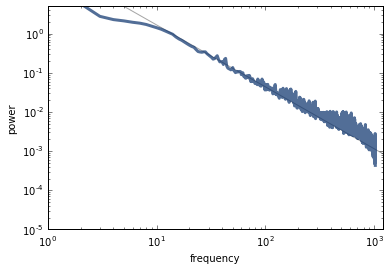

In [55]:
x = nperseg
ys = np.array([x**1.58, 1]) / 2.7e3
thinkplot.plot([1, x], ys, color='gray', linewidth=1)

thinkplot.plot(freqs, powers)
thinkplot.config(xlabel='frequency', xscale='log', xlim=[1, 1200],
                 ylabel='power', yscale='log', ylim=[1e-5, 5])

plt.savefig('chap08-6.pdf')

The slope of the line is -1.58, which indicates that this spectrum is pink noise with parameter $\beta=1.58$.

**Exercise:**  Choose a different value of `nperseg` and run this analysis again.  What are the pros and cons of larger segment lengths?  Modify the code to run the model longer and see if you can get a less noisy estimate of the spectrum.

## Exercises

**Exercise:** To test whether the distributions of `T` and `S` are heavy-tailed, we plotted their histograms on a log-log scale, which is what Bak, Tang and Wiesenfeld show in their paper.  But as we saw in Chapter 4, this visualization can obscure the shape of the distribution.  Using the same data, make a plot that shows the CDFs of `S` and `T`.  What can you say about the shape of these distributions?  Do they follow a power law?  Are they heavy tailed?

You might find it helpful to plot the CDFs on a log-x scale and on a log-log scale.

**Solution:** Here is the CDF of `S` on a log-x scale (left) and on a log-log scale (right).

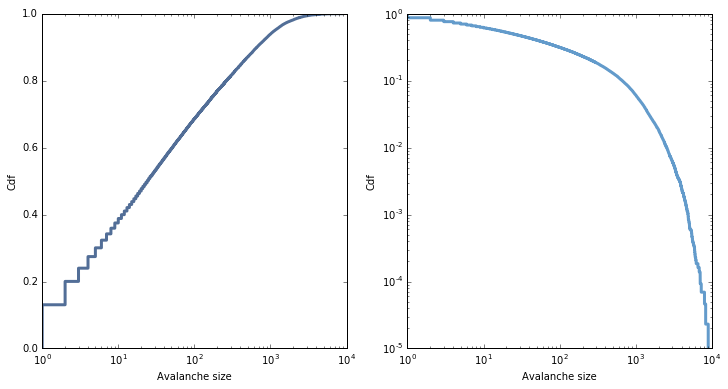

In [30]:
thinkplot.preplot(cols=2)

cdf = Cdf(S)
thinkplot.Cdf(cdf)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Cdf',
                 xscale='log')

thinkplot.subplot(2)
                  
thinkplot.Cdf(cdf, complement=True)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Cdf',
                 xscale='log',
                 yscale='log')

And here are the results for `T`.

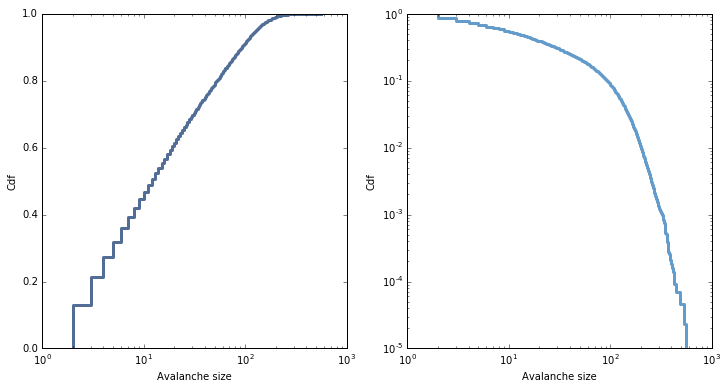

In [31]:
thinkplot.preplot(cols=2)

cdf = Cdf(T)
thinkplot.Cdf(cdf)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Cdf',
                 xscale='log')

thinkplot.subplot(2)
                  
thinkplot.Cdf(cdf, complement=True)
thinkplot.config(xlabel='Avalanche size',
                 ylabel='Cdf',
                 xscale='log',
                 yscale='log')

On the log-log scale, these CDFs are not straight, which indicates that they do not follow a power law.

However, on a log-x scale, they resemble lognormal distributions (with the left tail truncated).  The lognormal distribution is also considered heavy-tailed.

In my opinion, many papers in complexity science are too quick to identify power laws based on plots showing histograms or probability mass functions (PMFs).  I think many of these distributions, including both measurements from the world and results from simulations, are better modeled by other heavy-tailed distributions.

However, the argument the sand pile model is intended to make is valid either way: we observe that heavy-tailed distributions are common in natural systems, and SOC is a possible explanation, regardless of whether the distributions are specifically power law distributions or more generally heavy-tailed.

**Exercise:** In Section 8.5 we showed that the initial configuration of the sand pile model produces fractal patterns.  But after we drop a large number of random grains, the patterns look more random.

Starting with the example in Section 8.5, run the sand pile model for a while and then compute fractal dimensions for each of the 4 levels.  Is the sand pile model fractal in steady state?

**Solution:** I'll start with a copy of `pile4`.  Again the starting configuration looks fractal.

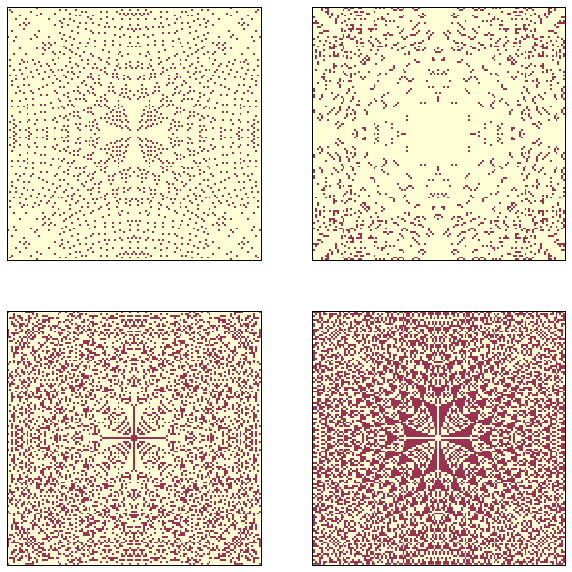

In [57]:
from copy import deepcopy

pile4 = deepcopy(pile3)
viewer4 = SandPileViewer(pile4)
draw_four(viewer4)

After it runs for a while, it looks pretty random.  But we have to be careful; people are not very good at judging what is random or not.

In [59]:
for i in range(10000):
    pile4.drop_and_run()

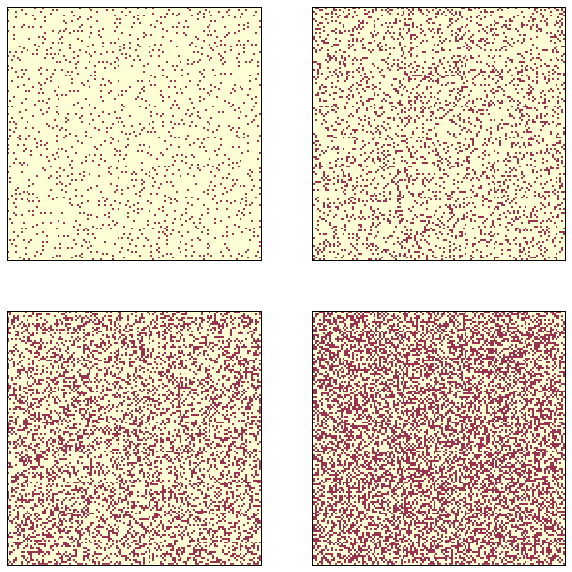

In [60]:
draw_four(viewer4)

Here are the results from the box counting algorithm.  The lines are reasonably straight, which means our estimates of the fractal dimension are valid.

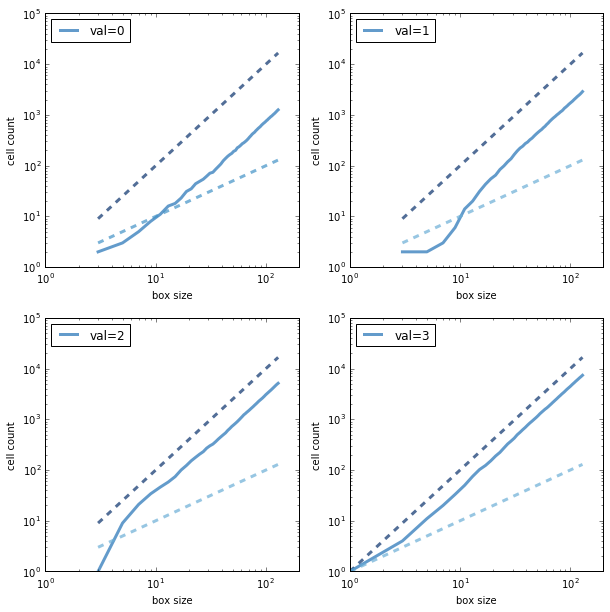

In [61]:
dims = box_count_four(pile4)

And here are the fractal dimensions.

In [62]:
for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))

0  1.864
1  2.142
2  2.006
3  1.960


They all seem to be converging on 2, which is what we expect from a totally random pattern.  It's hard to say for sure, because it's possible that they are still fractal with dimensions close to 2, but not exactly 2.  But I think that's unlikely.

I think this observation undermines the SOC argument to some degree.  If the sand pile model is not fractal in steady state, it does not explain the prevalence of fractal geometry in natural systems.

**Exercise:** Another version of the sand pile model, called the "single source" model, starts from a different initial condition: instead of all cells at the same level, all cells are set to 0 except the center cell, which is set to a very large value.

Write a function that creates a `SandPile` object, sets up the single source initial condition, and runs until the pile reaches equilibrium.  Does the results appear to be fractal?

You can read more about this version of the sand pile model at http://math.cmu.edu/~wes/sandgallery.html

**Solution:**  The following function clears all cells and puts a tower in the center.

In [63]:
def single_source(pile, height=1024):
    """Adds a tower to the center cell.
    
    height: value assigned to the center cell
    """
    a = pile.array
    n, m = a.shape
    a[:, :] = 0
    a[n//2, m//2] = height

`run_ss_pile` builds a single-source sand pile and runs until equilibrium.

In [64]:
def run_ss_pile(n, k=10):
    """Runs a single source model.
    
    k: integer power of two of height
    """
    pile = SandPile(n)
    single_source(pile, 2**k)
    print(pile.run())        
    viewer = SandPileViewer(pile)
    return pile, viewer

Let's try it with `2**14` grains:

(14244, 4900462)
CPU times: user 5.85 s, sys: 0 ns, total: 5.85 s
Wall time: 5.85 s


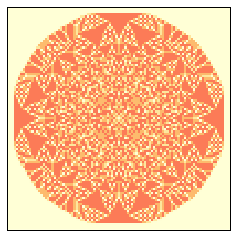

In [65]:
% time pile5, viewer5 = run_ss_pile(n=101, k=14)
viewer5.draw()

Visually, the results sure look fractal.

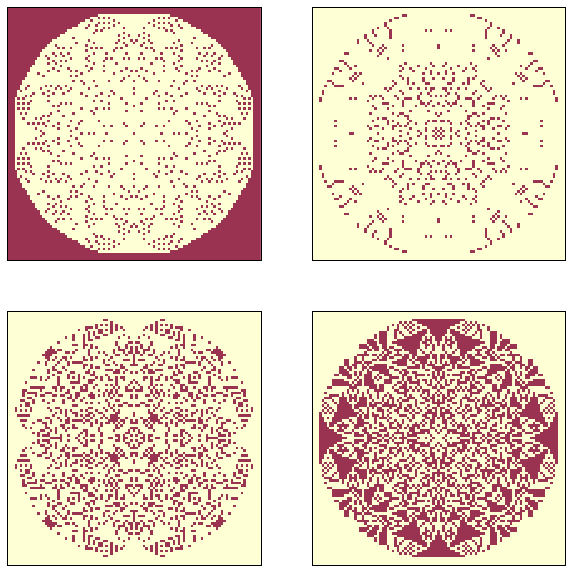

In [66]:
draw_four(viewer5)

And here are the results from the box counting algorithm.

For value 0, the line gets steeper at the end because of the boundary cells.

For the other values, it drops off at the end.

So the estimated dimensions might not be very accurate.  A better alternative would be a radial version of the box counting algorithm.

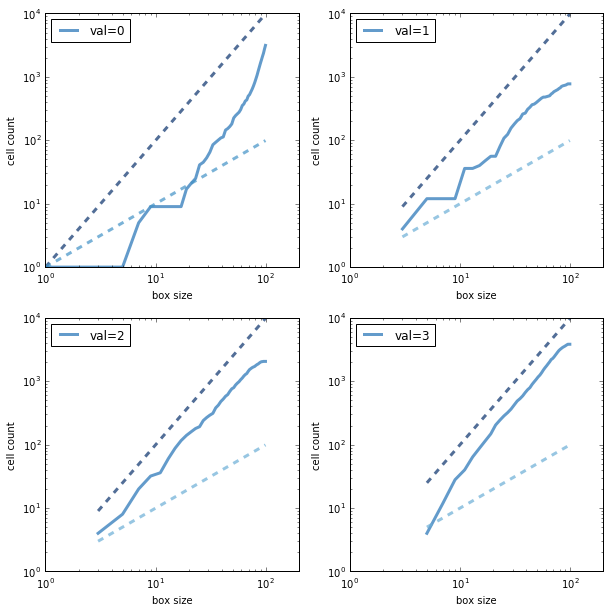

In [67]:
dims = box_count_four(pile5)

The results are not as clear as we might like, but at least some of these patterns seem to have non-integer dimensions.

In [68]:
for i, dim in enumerate(dims):
    print('%d  %0.3f' % (i, dim))

0  2.094
1  1.598
2  1.848
3  2.185


In the repository for this book, you'll find a notebook called `sspile` that does a more careful job of estimating these dimensions.